Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Resource Conservation and Recovery Act Inspections by Congressional District

This notebook examines ECHO data using ECHO_EXPORTER, RCRA_FACILITIES,
and RCRA_EVALUATIONS.

From ECHO_EXPORTER:
<ul>
    <li>RCRA_IDS - to match facilities/violations in RCRA_FACILITIES and RCRA_EVALUATIONS</li>
    <li>FAC_DERIVED_CD113 - 113th congressional district</li>
    <li>FAC_LAT and FAC_LONG - latitude and longitude</li>
    <li>RCRA_PERMIT_TYPES</li>
</ul>

RCRA Permit Types include:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

From RCRA_EVALUATIONS we get:
<ul>
    <li>EVALUATION_DESC - a description of the evaluation</li>
    <li>EVALUATION_AGENCY - the agency that conducted the evaluation</li>
    <li>EVALUATION_START_DATE</li>
</ul>

A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [3]:
my_state = dropdown_state.value

sql = "select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, RCRA_IDS, " + \
    "RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'" + \
    "and FAC_STATE = '" + my_state + "'" 
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, RCRA_IDS, RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'and FAC_STATE = 'NC'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20RCRA_IDS%2C%20RCRA_PERMIT_TYPES%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20RCRA_FLAG%20%3D%20%27Y%27and%20FAC_STATE%20%3D%20%27NC%27


In [4]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
num_facilities = echo_data.shape[0]

print("There are %s RCRA facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 15550 RCRA facilities in NC tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [5]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…



Run this next cell after choosing a congressional district from the dropdown list.

In [6]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s RCRA facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 882 RCRA facilities in NC district 9 tracked in the ECHO database.


Next look up the inspection history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [7]:
sql = "select ID_NUMBER, EVALUATION_DESC, EVALUATION_AGENCY, EVALUATION_START_DATE " + \
        " from `RCRA_EVALUATIONS` where ID_NUMBER like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
# print(data_location)
rcra_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
rcra_data.set_index( "ID_NUMBER", inplace=True)
rcra_data

,EVALUATION_DESC,EVALUATION_AGENCY,EVALUATION_START_DATE
ID_NUMBER,,,
NC0000015198,FOCUSED COMPLIANCE INSPECTION,S,05/28/1996
NC0000015222,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,11/13/2013
NC0000015222,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,12/14/2018
NC0000015248,COMPLIANCE ASSISTANCE VISIT,S,12/14/2010
NC0000015248,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,03/09/2012
...,...,...,...
NCT000002357,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,03/07/2003
NCT000653576,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,11/19/2004
NCT000653576,COMPLIANCE SCHEDULE EVALUATION,S,02/15/2005


In [8]:
# The RCRA_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in RCRA_VIOLATION_HISTORY.

cd_rcra = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # print( type( fac ))
    # breakpoint()
    ids = fac.RCRA_IDS
    # Look at each RCRA_ID belonging to the facility
    for rcra_id in ids.split():
        try:
            # Find the rcra_id in the RCRA_VIOLATION_HISTORY, if any exist there.
            # It can match a ID_NUMBER, which is the index of rcra_data.
            rcra_fac = rcra_data.loc[ rcra_id ].copy()
            # Add the facility's index number to rcra_fac, to refer to it.
            n = rcra_fac.shape[0]
            fac_list = [fac.Index] * n
            rcra_fac['facility'] = fac_list
            # Make a frame that contains the violations.  Add it to my_cd_icis.
            frames = [cd_rcra, rcra_fac]
            cd_rcra = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in RCRA_VIOLATION_HISTORY.
            no_data_ids.append( rcra_id )

cd_rcra

# my_cd_icis.to_csv( r'my_cd_icis.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

,0,EVALUATION_AGENCY,EVALUATION_DESC,EVALUATION_START_DATE,facility
NCD986194421,NaN,S,SIGNIFICANT NON-COMPLIER,08/02/1991,22.0
NCD986194421,NaN,S,NOT A SIGNIFICANT NON-COMPLIER,09/02/1993,22.0
NCD986194421,NaN,S,CASE DEVELOPMENT INSPECTION,08/02/1991,22.0
NCD986194421,NaN,S,FOCUSED COMPLIANCE INSPECTION,08/06/1991,22.0
NCD986194421,NaN,S,FOLLOW-UP INSPECTION,02/10/1992,22.0
...,...,...,...,...,...
facility,"[15480, 15480, 15480]",NaN,NaN,NaN,NaN
EVALUATION_DESC,FOCUSED COMPLIANCE INSPECTION,NaN,NaN,NaN,NaN
EVALUATION_AGENCY,S,NaN,NaN,NaN,NaN
EVALUATION_START_DATE,11/24/2010,NaN,NaN,NaN,NaN


In [9]:
fac_idx_list = cd_rcra['facility'].dropna()
fac_cd_rcra = my_cd_facs.loc[fac_idx_list]
fac_cd_rcra

,FAC_NAME,FAC_STATE,FAC_LAT,FAC_LONG,RCRA_IDS,RCRA_PERMIT_TYPES,FAC_DERIVED_CD113
22.0,EQUIPMENT AND SUPPLY INC,NC,35.04492,-80.61155,NCD986194421,"SQG, TSDF",9.0
22.0,EQUIPMENT AND SUPPLY INC,NC,35.04492,-80.61155,NCD986194421,"SQG, TSDF",9.0
22.0,EQUIPMENT AND SUPPLY INC,NC,35.04492,-80.61155,NCD986194421,"SQG, TSDF",9.0
22.0,EQUIPMENT AND SUPPLY INC,NC,35.04492,-80.61155,NCD986194421,"SQG, TSDF",9.0
22.0,EQUIPMENT AND SUPPLY INC,NC,35.04492,-80.61155,NCD986194421,"SQG, TSDF",9.0
...,...,...,...,...,...,...,...
15316.0,CVS PHARMACY #6402,NC,35.49830,-80.84888,NCR000152702,LQG,9.0
15463.0,NOVANT HEALTH CHARLOTTE ORTHOPEDIC HOSPITAL,NC,35.20987,-80.82374,NCD980799043,LQG,9.0
15463.0,NOVANT HEALTH CHARLOTTE ORTHOPEDIC HOSPITAL,NC,35.20987,-80.82374,NCD980799043,LQG,9.0
15463.0,NOVANT HEALTH CHARLOTTE ORTHOPEDIC HOSPITAL,NC,35.20987,-80.82374,NCD980799043,LQG,9.0


Save the data to a CSV file in your Google Drive.
The first of the next three cells will open our Google Drive to write into.
The second cell writes the congressional district file.
The third cell writes the file for state data.
Running these cells is optional.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Write the congressional district data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/cd-rcra-inspections-' + my_state + '-' + str( my_cd ) + '.csv'
cd_rcra.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

Write the state data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/state-rcra-inspections-' + my_state + '.csv'
rcra_data.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

Map the facilities that have had these serious CAA violations.

In [10]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_cd = mapper(fac_cd_rcra)
map_of_facilities_in_cd

Present another dropdown with the list of names of the facilities.  Choosing a facility will display the evaluations.

In [12]:
cd_array = fac_cd_rcra["FAC_NAME"].dropna().unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('A & A TOWING', 'A CLEANER WORLD NO 115', 'ABT INCORPORATED', …

Run this next cell after choosing a facility.

RCRA Permit Types:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

In [13]:
my_fac = fac_cd_rcra[fac_cd_rcra["FAC_NAME"] == w3.value]
evaluations = cd_rcra[cd_rcra['facility'] == my_fac.iloc[[0]].index[0]]
print( my_fac.iloc[0] )
evaluations


FAC_NAME             PACE ANALYTICAL SERVICES, LLC
FAC_STATE                                       NC
FAC_LAT                                    35.4044
FAC_LONG                                  -80.8631
RCRA_IDS                              NCD986205086
RCRA_PERMIT_TYPES                              SQG
FAC_DERIVED_CD113                                9
Name: 963.0, dtype: object


,0,EVALUATION_AGENCY,EVALUATION_DESC,EVALUATION_START_DATE,facility
NCD986205086,NaN,S,COMPLIANCE EVALUATION INSPECTION ON-SITE,07/12/1996,963.0
NCD986205086,NaN,S,COMPLIANCE EVALUATION INSPECTION ON-SITE,12/07/2005,963.0
NCD986205086,NaN,S,COMPLIANCE SCHEDULE EVALUATION,01/25/2006,963.0
NCD986205086,NaN,S,COMPLIANCE SCHEDULE EVALUATION,07/29/2010,963.0
NCD986205086,NaN,S,COMPLIANCE EVALUATION INSPECTION ON-SITE,06/18/2010,963.0


In [14]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

## Plot the number of evaluations by year for the congressional district.

                 YEAR_EVALUATION
YEAR_EVALUATION                 
6.0                            2
1983.0                         4
1984.0                        33
1985.0                        44
1986.0                        24
1987.0                        53
1988.0                        80
1989.0                        75
1990.0                        63
1991.0                       115
1992.0                       144
1993.0                       109
1994.0                       110
1995.0                        95
1996.0                        68
1997.0                        67
1998.0                        52
1999.0                        65
2000.0                        49
2001.0                        47
2002.0                        33
2003.0                        52
2004.0                        66
2005.0                        68
2006.0                        76
2007.0                        76
2008.0                        70
2009.0                        63
2010.0    

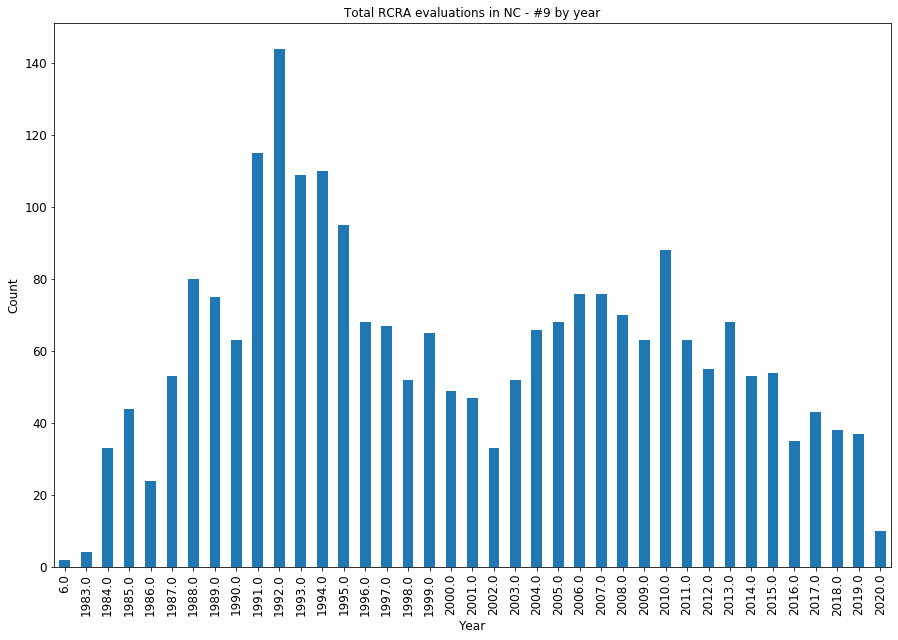

In [15]:
chart_title = "Total RCRA evaluations"

show_plot( cd_rcra, 'EVALUATION_START_DATE', 'YEAR_EVALUATION', \
          my_state + ' - #' + str( my_cd ), '%m/%d/%Y', chart_title )

## Plot the number of evaluations by year, using the entire state.
Since the number of evaluations in a single CD may be small, it can be more
interesting to look at the entire state.

                 YEAR_EVALUATION
YEAR_EVALUATION                 
6                              6
1901                           3
1919                           4
1961                           1
1981                           1
1982                           1
1983                         105
1984                         686
1985                         716
1986                         689
1987                         988
1988                        1370
1989                        1374
1990                        1346
1991                        1687
1992                        1965
1993                        2103
1994                        2257
1995                        2525
1996                        1446
1997                        1491
1998                        1471
1999                        1129
2000                        1112
2001                        1200
2002                        1037
2003                        1197
2004                        1077
2005      

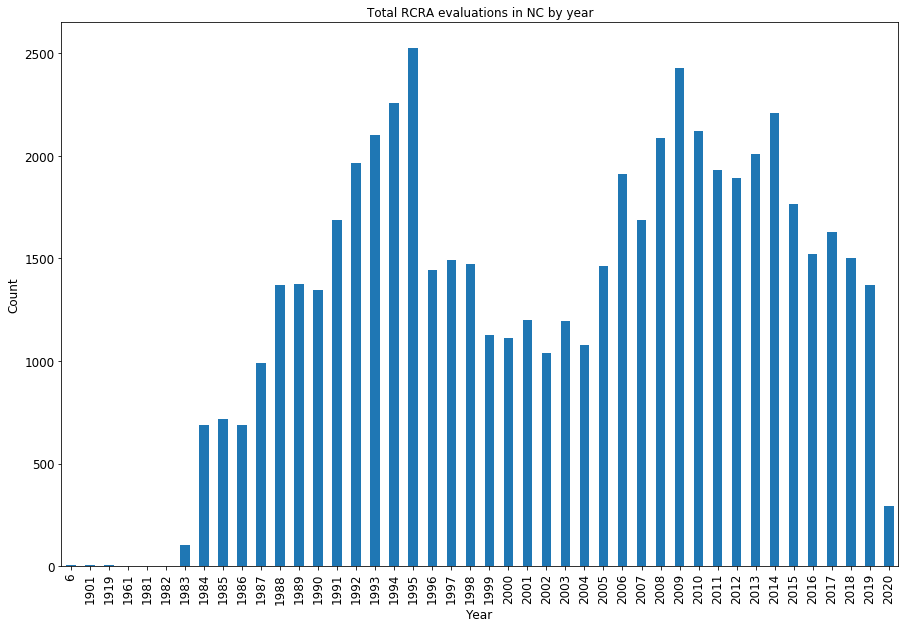

In [16]:
show_plot( rcra_data, 'EVALUATION_START_DATE', 'YEAR_EVALUATION', \
          my_state, '%m/%d/%Y', chart_title )